In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn


# Now try importing your modules
from src.utils import compute_mad_and_madgap, compute_energy
from src.dataset import get_Cora
from src.models import GCN, GAT, GraphSAGE, ChebNet, EnhancedGAT
from src.training import training_pipeline_cora, test_cora
from src.visualize import tsne, plot_cora
from src.AdaEdge import AdaEdge

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [30]:
dataset = get_Cora()


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [31]:
num_epochs = 200
lr = 0.01
loss_fcn = nn.CrossEntropyLoss()
regularization_params = [0, 0.01, 0.1]
num_layers = [2, 3, 4, 5, 6]
adaedge_iters = 5
runs_per_config = 5

results = {
    'Model': [],
    'Num_Layers': [],
    'AdaEdge': [],
    'RemovalRate': [],
    'AdditionRate': [],
    'MAD': [],
    'MADGap': [],
    'MADReg': [],
    'Accuracy': [],
    'Energy': []
}

for model_class in [GCN, GAT, GraphSAGE, ChebNet, EnhancedGAT]:
    
    if model_class == GAT: # scatter is not supported in mps
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for num_layer in num_layers:
        for lambda_reg in regularization_params:
            for adaedge in [False, True]:


                accuracies, mads, madgaps, removal_rates, addition_rates, energies = [], [], [], [], [],[]

                for _ in range(runs_per_config):
                    model = model_class(dataset.num_features, 16, dataset.num_classes, num_layer).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    mad, mad_gap = compute_mad_and_madgap(model, dataset, device)
                    energy = compute_energy(model, dataset, device)

                    if adaedge:
                        final_model, removal_rate, addition_rate = AdaEdge(lambda: model_class(dataset.num_features, 16, dataset.num_classes, num_layer),
                                              loss_fcn, lambda params: torch.optim.Adam(params, lr=lr),
                                              dataset, device, lambda_reg=lambda_reg, max_epochs=num_epochs, adaedge_iters=adaedge_iters)
                    else:
                        training_pipeline_cora(model, loss_fcn, optimizer, dataset, device, lambda_reg=lambda_reg, max_epochs=num_epochs)
                        removal_rate, addition_rate = 0, 0
                        final_model = model

                    acc = test_cora(final_model, dataset, device)
                    
                    accuracies.append(acc)
                    mads.append(mad)
                    madgaps.append(mad_gap)
                    energies.append(energy)
                    removal_rates.append(removal_rate)
                    addition_rates.append(addition_rate)


                # Compute mean and standard deviation for each metric
                mean_accuracy = np.mean(accuracies)
                std_accuracy = np.std(accuracies)
                mean_mad = np.mean(mads)
                std_mad = np.std(mads)
                mean_madgap = np.mean(madgaps)
                std_madgap = np.std(madgaps)
                mean_removal_rate = np.mean(removal_rates)
                std_removal_rate = np.std(removal_rates)
                mean_addition_rate = np.mean(addition_rates)
                std_addition_rate = np.std(addition_rates)
                mean_energy = np.mean(energies)

                # Store the results along with their standard deviation
                results['Model'].append(model_class.__name__)
                results['Num_Layers'].append(num_layer)
                results['AdaEdge'].append(adaedge)
                results['RemovalRate'].append(f"{mean_removal_rate:.4f} ± {std_removal_rate:.4f}")
                results['AdditionRate'].append(f"{mean_addition_rate:.4f} ± {std_addition_rate:.4f}")
                results['MAD'].append(f"{mean_mad:.4f} ± {std_mad:.4f}")
                results['MADGap'].append(f"{mean_madgap:.4f} ± {std_madgap:.4f}")
                results['MADReg'].append(lambda_reg)
                results['Accuracy'].append(f"{mean_accuracy:.4f} ± {std_accuracy:.4f}")
                results['Energy'].append(mean_energy)

results_df = pd.DataFrame(results)
results_df.to_csv('../results/results.csv')

Training the GCN model for 2 layers with MADReg = 0
Starting training...
Epoch 00001 | Train Loss: 1.9455 | Val Loss: 1.9389 | Val Accuracy: 0.3160
Epoch 00051 | Train Loss: 0.7463 | Val Loss: 1.2131 | Val Accuracy: 0.7740
Early stopping triggered after 65 epochs due to no improvement in validation accuracy.
Test Accuracy: 0.7410
Training the GCN model for 2 layers with MADReg = 0
Starting training...
Epoch 00001 | Train Loss: 1.9464 | Val Loss: 1.9429 | Val Accuracy: 0.2060
Early stopping triggered after 42 epochs due to no improvement in validation accuracy.
Test Accuracy: 0.6770
Training the GCN model for 2 layers with MADReg = 0
Starting training...
Epoch 00001 | Train Loss: 1.9458 | Val Loss: 1.9444 | Val Accuracy: 0.1400
Epoch 00051 | Train Loss: 0.7464 | Val Loss: 1.2002 | Val Accuracy: 0.7720
Early stopping triggered after 67 epochs due to no improvement in validation accuracy.
Test Accuracy: 0.7790
Training the GCN model for 2 layers with MADReg = 0
Starting training...
Epoch 

In [107]:
results_df = pd.read_csv('../results/results.csv')

In [118]:
# Split MAD and MADGap values into mean and std for plotting
results_df[['MAD_mean', 'MAD_std']] = results_df['MAD'].str.split(' ± ', expand=True).astype(float)
results_df[['MADGap_mean', 'MADGap_std']] = results_df['MADGap'].str.split(' ± ', expand=True).astype(float)
results_df[['Accuracy_mean', 'Accuracy_std']] = results_df['Accuracy'].str.split(' ± ', expand=True).astype(float)
results_df[['RemovalRate_mean', 'RemovalRate_std']] = results_df['RemovalRate'].str.split(' ± ', expand=True).astype(float)
results_df[['AdditionRate_mean', 'AdditionRate_std']] = results_df['AdditionRate'].str.split(' ± ', expand=True).astype(float)
results['MADReg'] = results_df['MADReg'].astype(float)

,Unnamed: 0,Model,Num_Layers,AdaEdge,RemovalRate,AdditionRate,MAD,MADGap,MADReg,Accuracy,...,MAD_mean,MAD_std,MADGap_mean,MADGap_std,Accuracy_mean,Accuracy_std,RemovalRate_mean,RemovalRate_std,AdditionRate_mean,AdditionRate_std
0,0,GCN,2,False,0.0000 ± 0.0000,0.0000 ± 0.0000,0.4668 ± 0.1089,0.2552 ± 0.0387,0.00,0.7224 ± 0.0348,...,0.4668,0.1089,0.2552,0.0387,0.7224,0.0348,0.0000,0.0000,0.0000,0.0000
1,1,GCN,2,True,0.0004 ± 0.0000,0.2003 ± 0.0010,0.4936 ± 0.2036,0.2399 ± 0.0671,0.00,0.7152 ± 0.0388,...,0.4936,0.2036,0.2399,0.0671,0.7152,0.0388,0.0004,0.0000,0.2003,0.0010
2,2,GCN,2,False,0.0000 ± 0.0000,0.0000 ± 0.0000,0.5378 ± 0.0625,0.2686 ± 0.0314,0.01,0.7408 ± 0.0482,...,0.5378,0.0625,0.2686,0.0314,0.7408,0.0482,0.0000,0.0000,0.0000,0.0000
3,3,GCN,2,True,0.0004 ± 0.0001,0.2011 ± 0.0021,0.4386 ± 0.1301,0.2196 ± 0.0460,0.01,0.7190 ± 0.0359,...,0.4386,0.1301,0.2196,0.0460,0.7190,0.0359,0.0004,0.0001,0.2011,0.0021
4,4,GCN,2,False,0.0000 ± 0.0000,0.0000 ± 0.0000,0.4722 ± 0.1334,0.2577 ± 0.0365,0.10,0.7242 ± 0.0631,...,0.4722,0.1334,0.2577,0.0365,0.7242,0.0631,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,145,EnhancedGAT,6,True,0.0000 ± 0.0000,0.6478 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000,0.00,0.1214 ± 0.0225,...,0.0000,0.0000,0.0000,0.0000,0.1214,0.0225,0.0000,0.0000,0.6478,0.0000
146,146,EnhancedGAT,6,False,0.0000 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000,-0.0000 ± 0.0000,0.01,0.1362 ± 0.0952,...,0.0000,0.0000,-0.0000,0.0000,0.1362,0.0952,0.0000,0.0000,0.0000,0.0000
147,147,EnhancedGAT,6,True,0.0000 ± 0.0000,0.6478 ± 0.0000,-0.0000 ± 0.0000,-0.0000 ± 0.0000,0.01,0.0864 ± 0.0330,...,-0.0000,0.0000,-0.0000,0.0000,0.0864,0.0330,0.0000,0.0000,0.6478,0.0000
148,148,EnhancedGAT,6,False,0.0000 ± 0.0000,0.0000 ± 0.0000,-0.0000 ± 0.0000,0.0000 ± 0.0000,0.10,0.1330 ± 0.0809,...,-0.0000,0.0000,0.0000,0.0000,0.1330,0.0809,0.0000,0.0000,0.0000,0.0000


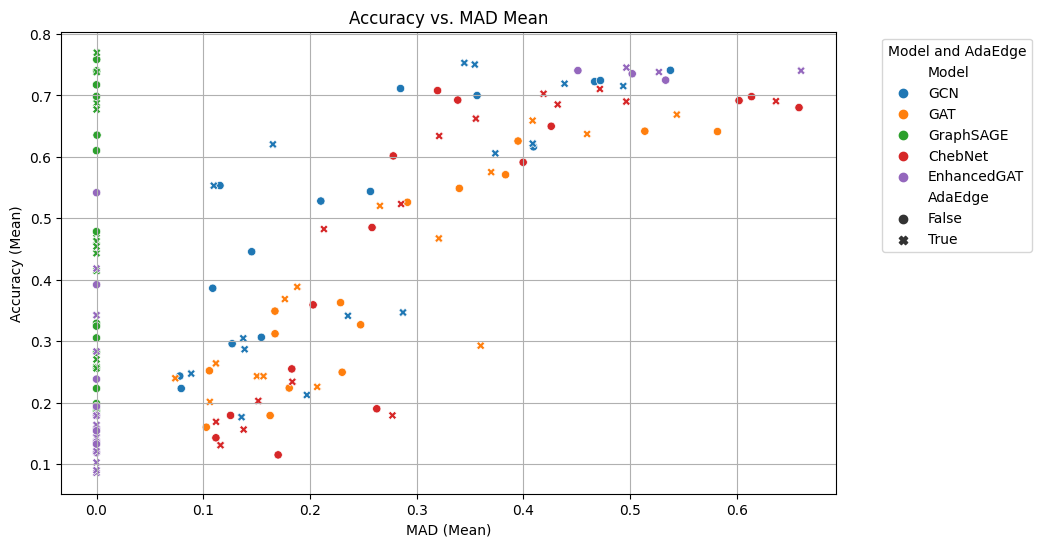

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='MAD_mean', y='Accuracy_mean', hue='Model', style='AdaEdge')
plt.title('Accuracy vs. MAD Mean')
plt.xlabel('MAD (Mean)')
plt.ylabel('Accuracy (Mean)')
plt.legend(title='Model and AdaEdge', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


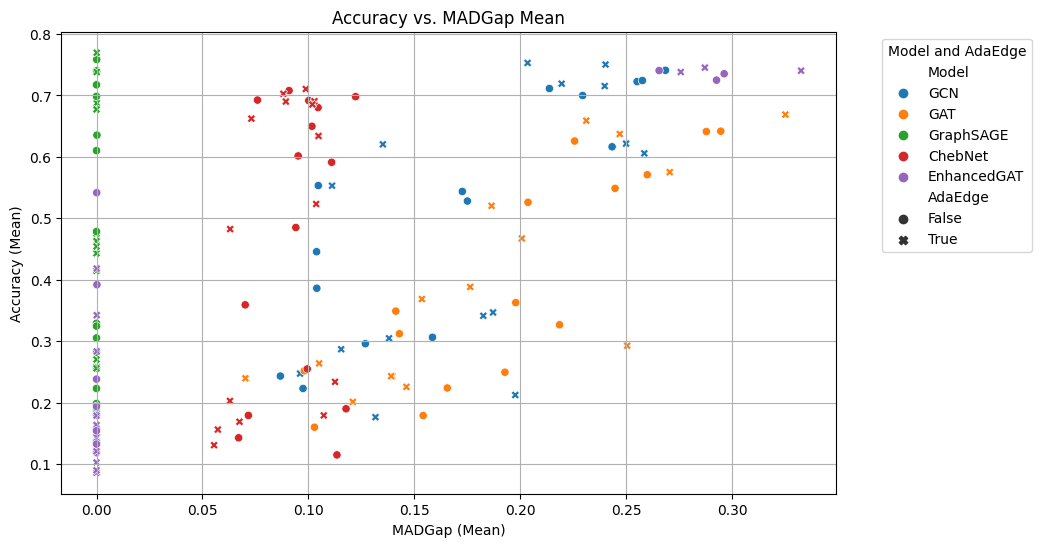

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='MADGap_mean', y='Accuracy_mean', hue='Model', style='AdaEdge')
plt.title('Accuracy vs. MADGap Mean')
plt.xlabel('MADGap (Mean)')
plt.ylabel('Accuracy (Mean)')
plt.legend(title='Model and AdaEdge', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


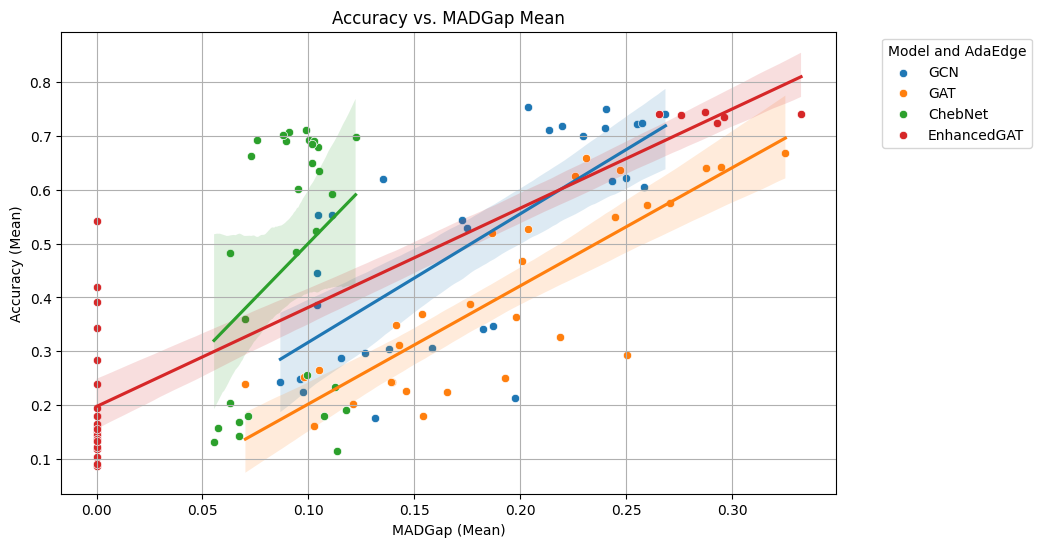

In [54]:
# Assuming results_df is your dataframe and it's already loaded with the required data.
plt.figure(figsize=(10, 6))

# Unique models in the dataframe
models = results_df['Model'].unique()

# Scatter plot for each model
for model in models:
    if model == "GraphSAGE":
        continue
    # Subset dataframe for the model
    subset = results_df[results_df['Model'] == model]
    
    # Scatter plot
    sns.scatterplot(data=subset, x='MADGap_mean', y='Accuracy_mean', label=model)
    
    # Regression line
    sns.regplot(data=subset, x='MADGap_mean', y='Accuracy_mean', scatter=False)

# Adding aesthetics
plt.title('Accuracy vs. MADGap Mean')
plt.xlabel('MADGap (Mean)')
plt.ylabel('Accuracy (Mean)')
plt.legend(title='Model and AdaEdge', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


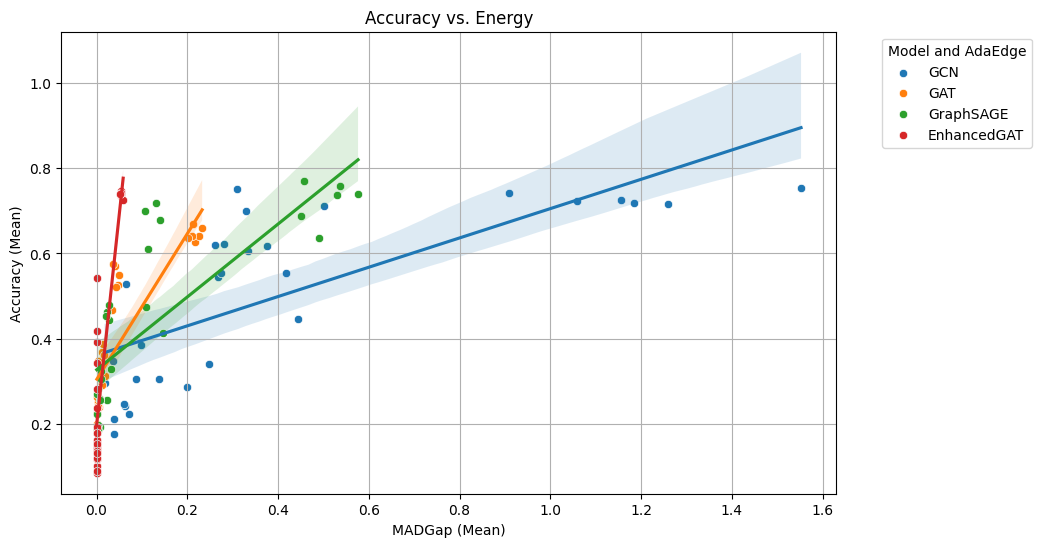

In [113]:
# Assuming results_df is your dataframe and it's already loaded with the required data.
plt.figure(figsize=(10, 6))

# Unique models in the dataframe
models = results_df['Model'].unique()

# Scatter plot for each model
for model in models:
    if model == "ChebNet":
        continue    
    # Subset dataframe for the model
    subset = results_df[results_df['Model'] == model]
    
    # Scatter plot
    sns.scatterplot(data=subset, x='Energy', y='Accuracy_mean', label=model)
    
    # Regression line
    sns.regplot(data=subset, x='Energy', y='Accuracy_mean', scatter=False)

# Adding aesthetics
plt.title('Accuracy vs. Energy')
plt.xlabel('MADGap (Mean)')
plt.ylabel('Accuracy (Mean)')
plt.legend(title='Model and AdaEdge', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


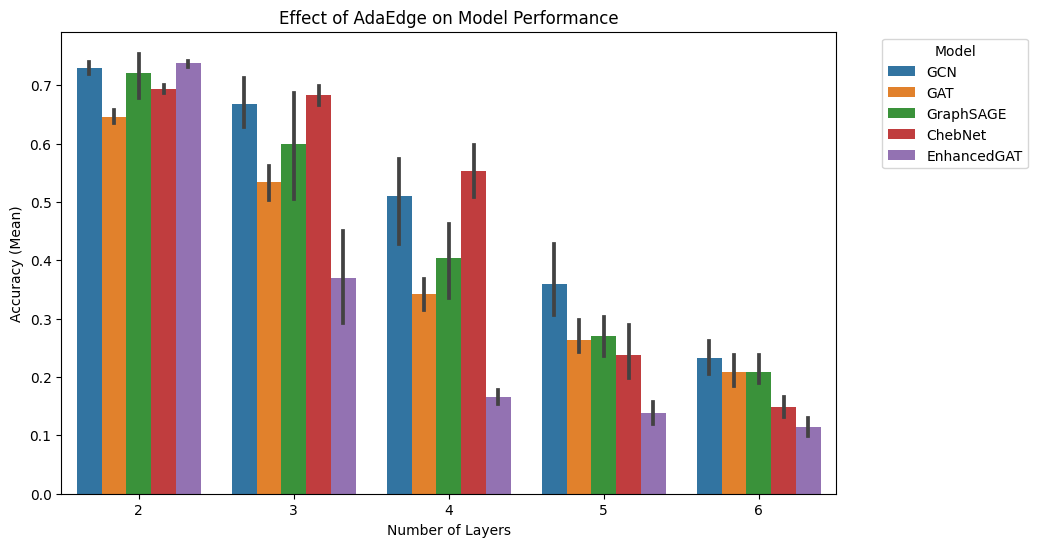

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Num_Layers', y='Accuracy_mean', hue='Model')
plt.title('Effect of AdaEdge on Model Performance')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy (Mean)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


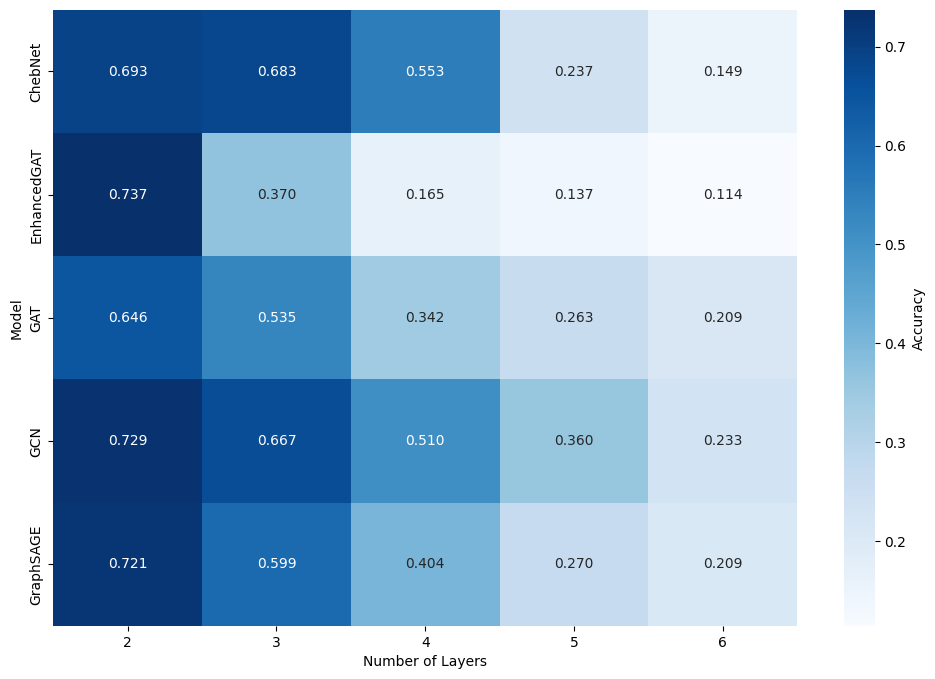

In [47]:
# Pivot the DataFrame to get a matrix of models x num_layers.
heatmap_data = results_df.pivot_table(index='Model', columns='Num_Layers', values='Accuracy_mean', aggfunc='mean')

# Now use seaborn to create the heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='Blues', cbar_kws={'label': 'Accuracy'})
plt.title('Effect of layers on model performance')
plt.xlabel('Number of Layers')
plt.ylabel('Model')
plt.show()

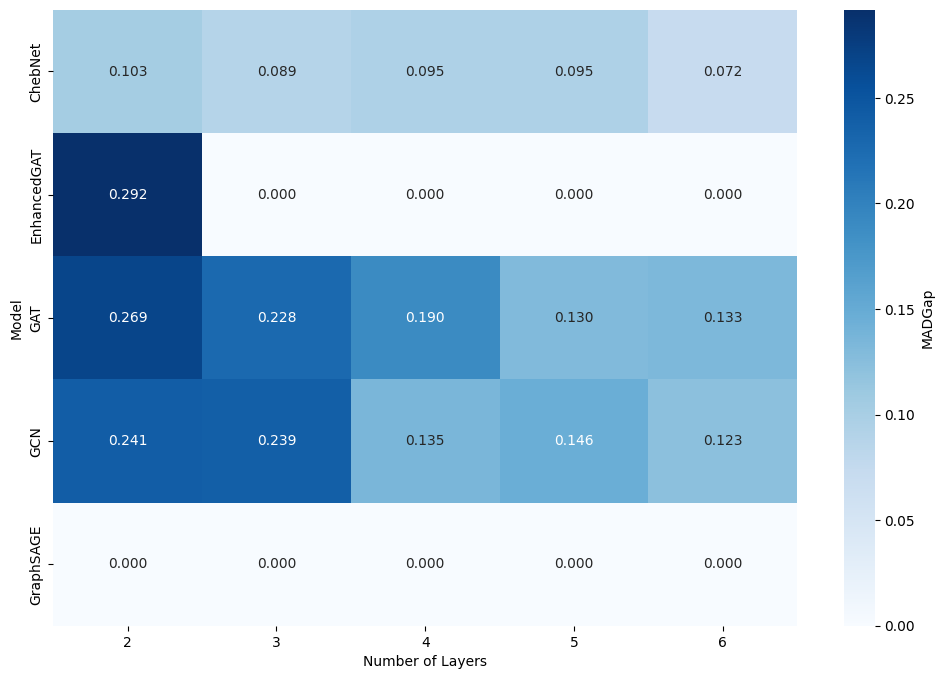

In [78]:
heatmap_data = results_df.pivot_table(index='Model', columns='Num_Layers', values='MADGap_mean', aggfunc='mean')

# Now use seaborn to create the heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='Blues', cbar_kws={'label': 'MADGap'})
plt.title('MADGap vs. Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Model')
plt.show()

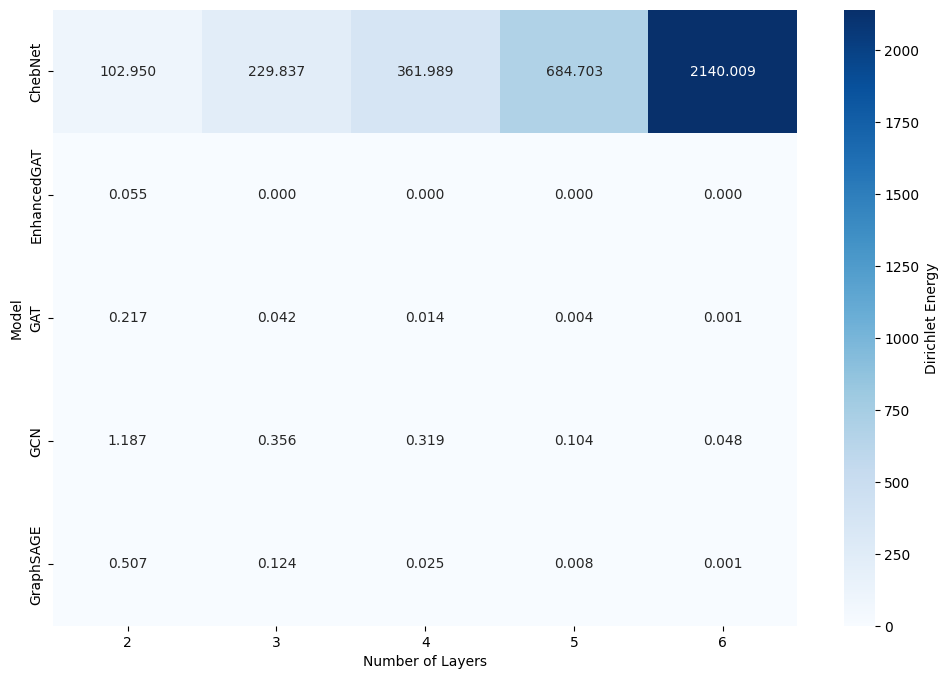

In [111]:
# Pivot the DataFrame to get a matrix of models x num_layers.
heatmap_data = results_df.pivot_table(index='Model', columns='Num_Layers', values='Energy', aggfunc='mean')

# Now use seaborn to create the heatmap.
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='Blues', cbar_kws={'label': 'Dirichlet Energy'})
plt.xlabel('Number of Layers')
plt.ylabel('Model')
plt.show()

In [74]:
# Create pivot table to see the effect of MADReg and layers on model performance (without AdaEdge)
pivot_data = results_df.pivot_table(index='Model', columns=['Num_Layers', 'MADReg'], values=['Accuracy'], aggfunc='first')

# Select layers 5 and 6
layers = [5, 6]
subset = pivot_data.loc[:, (slice(None), layers)]

Accuracy                                    \
Num_Layers                 5                                     
MADReg                  0.00             0.01             0.10   
Model                                                            
ChebNet      0.2552 ± 0.1346  0.1904 ± 0.0799  0.3594 ± 0.1439   
EnhancedGAT  0.1546 ± 0.0952  0.1332 ± 0.0958  0.1190 ± 0.0272   
GAT          0.2498 ± 0.0475  0.3492 ± 0.1126  0.2522 ± 0.1059   
GCN          0.5282 ± 0.1475  0.3864 ± 0.1530  0.3066 ± 0.1321   
GraphSAGE    0.3248 ± 0.1564  0.2820 ± 0.1251  0.3056 ± 0.1659   

                                                                
Num_Layers                 6                                    
MADReg                  0.00             0.01             0.10  
Model                                                           
ChebNet      0.1796 ± 0.0818  0.1432 ± 0.0740  0.1154 ± 0.0359  
EnhancedGAT  0.1190 ± 0.0249  0.1362 ± 0.0952  0.1330 ± 0.0809  
GAT          0.2242 ± 0.1044  0.1794 ± 0.0357  0.1604 ± 0.0463  
GCN          0.2436 ± 0.0873  0.2962 ± 0.0891  0.2234 ± 0.0841  
GraphSAGE    0.2234 ± 0.0999  0.1878 ± 0.0643  0.1990 ± 0.0480

In [76]:
# Compute the Pearson coefficient between accuracy and MADGap for each model
pearson_coefficients = {}
for model in models:
    subset = results_df[results_df['Model'] == model]
    pearson_coefficients[model] = pearsonr(subset['Accuracy_mean'], subset['MADGap_mean'])[0]

pearson_coefficients

{'GCN': 0.7250035901872144,
 'GAT': 0.8280796005082328,
 'GraphSAGE': 0.6128481919094952,
 'ChebNet': 0.33442586687592635,
 'EnhancedGAT': 0.9015269396418759}

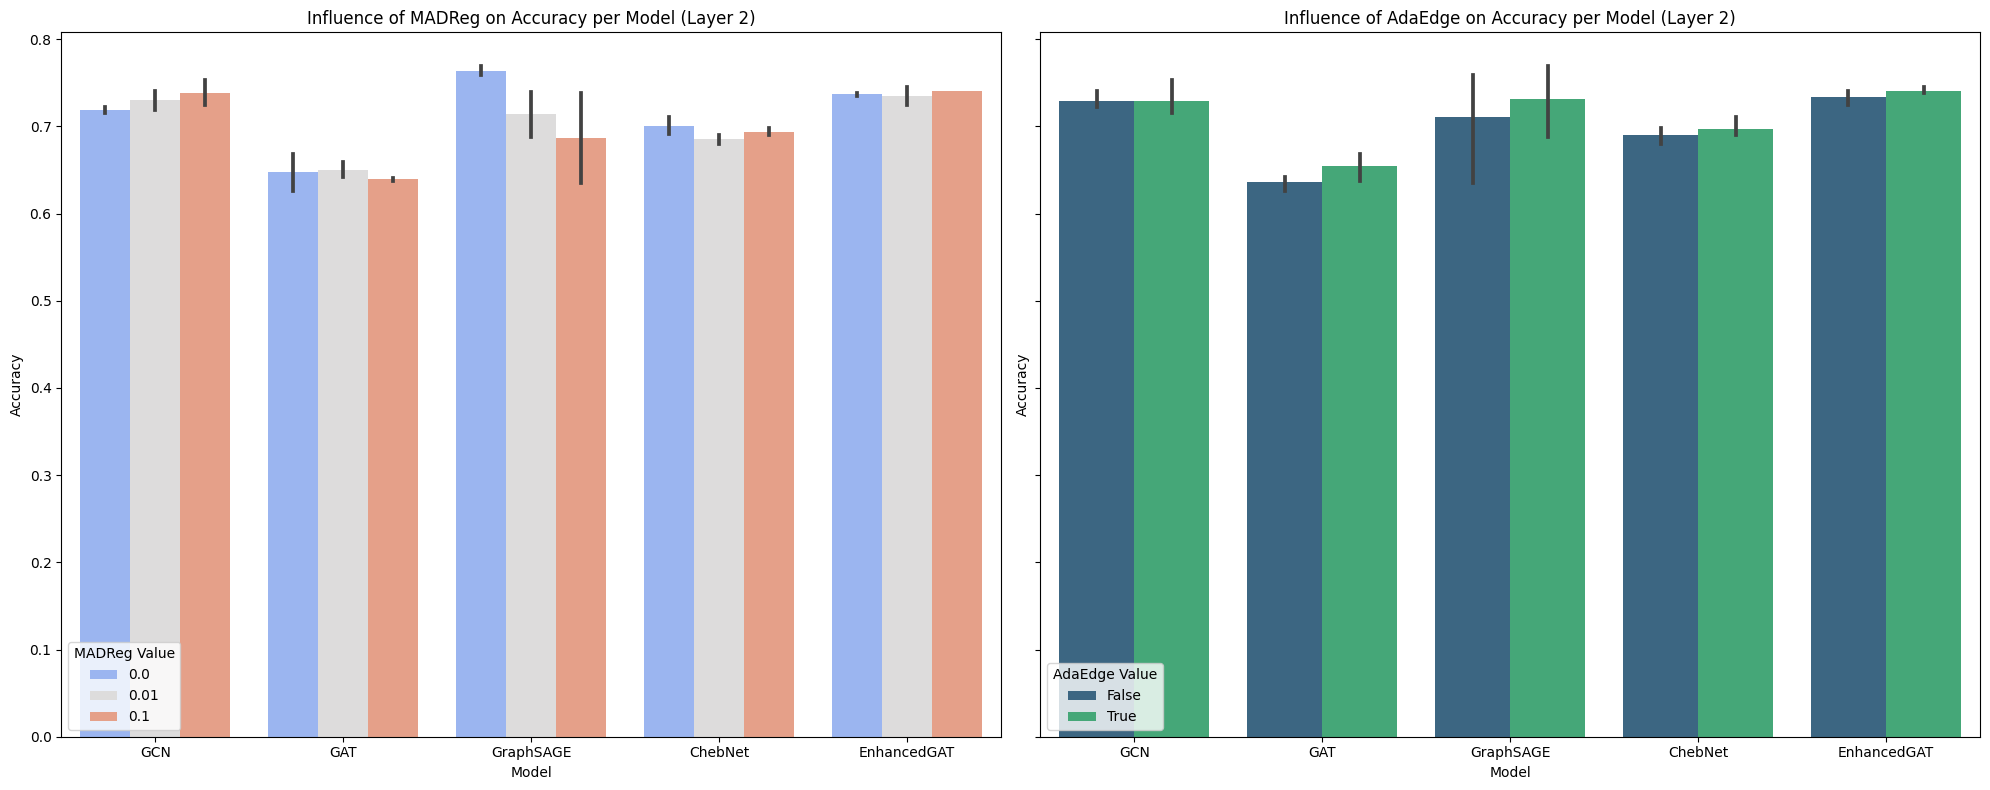

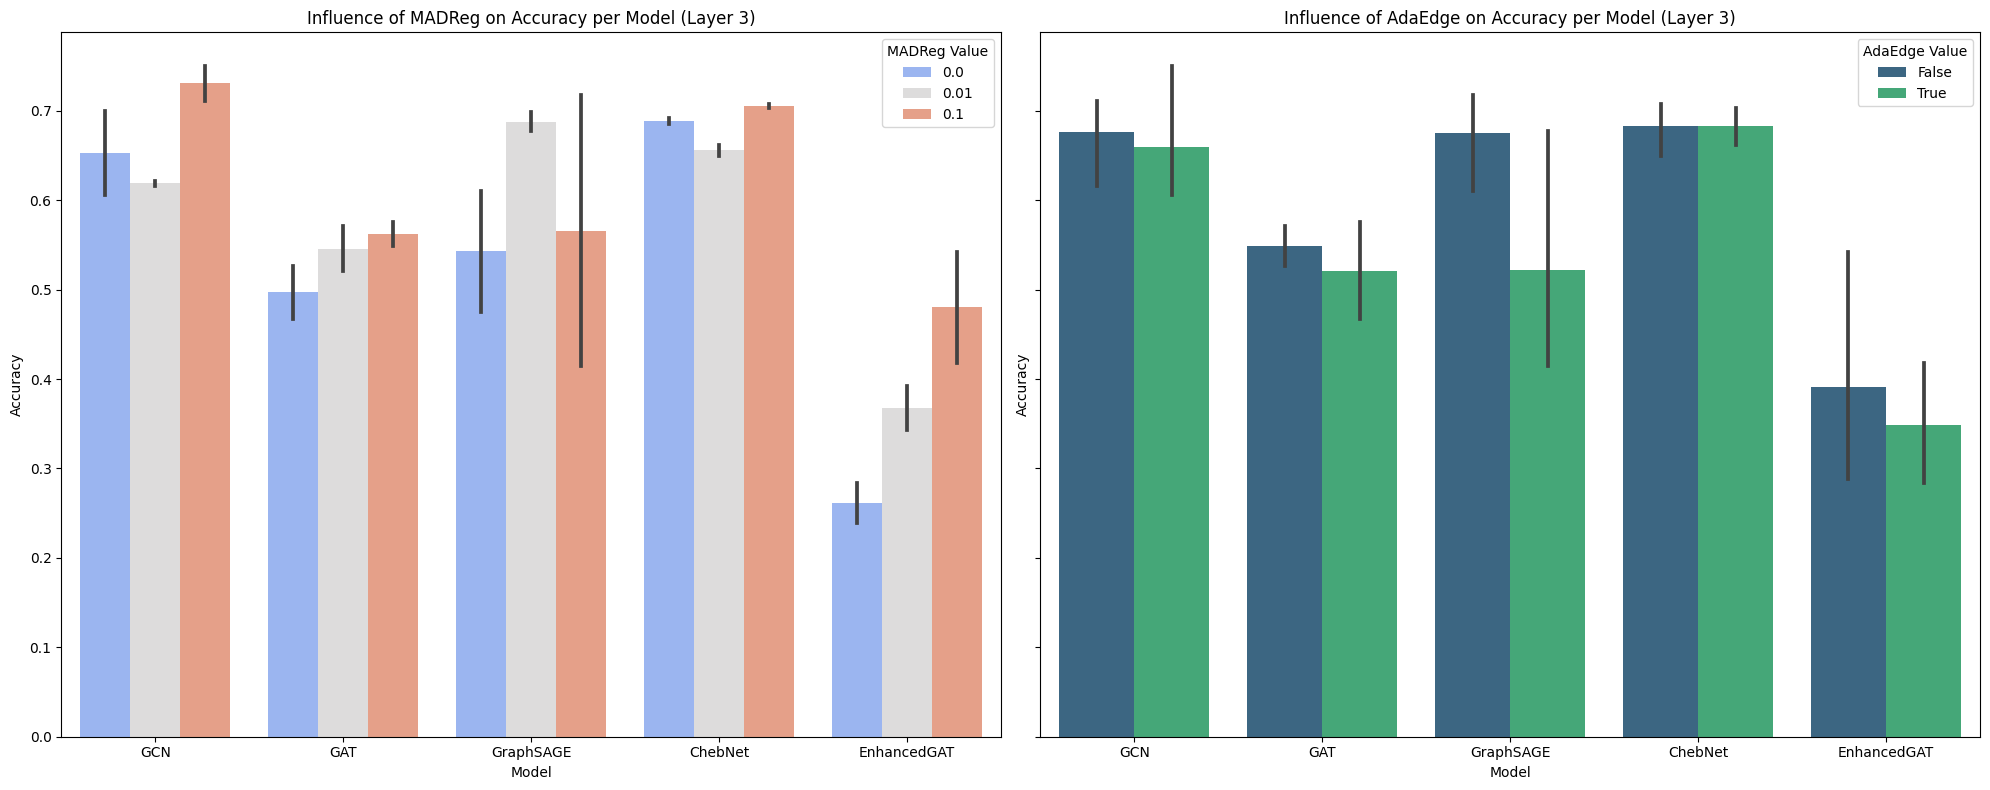

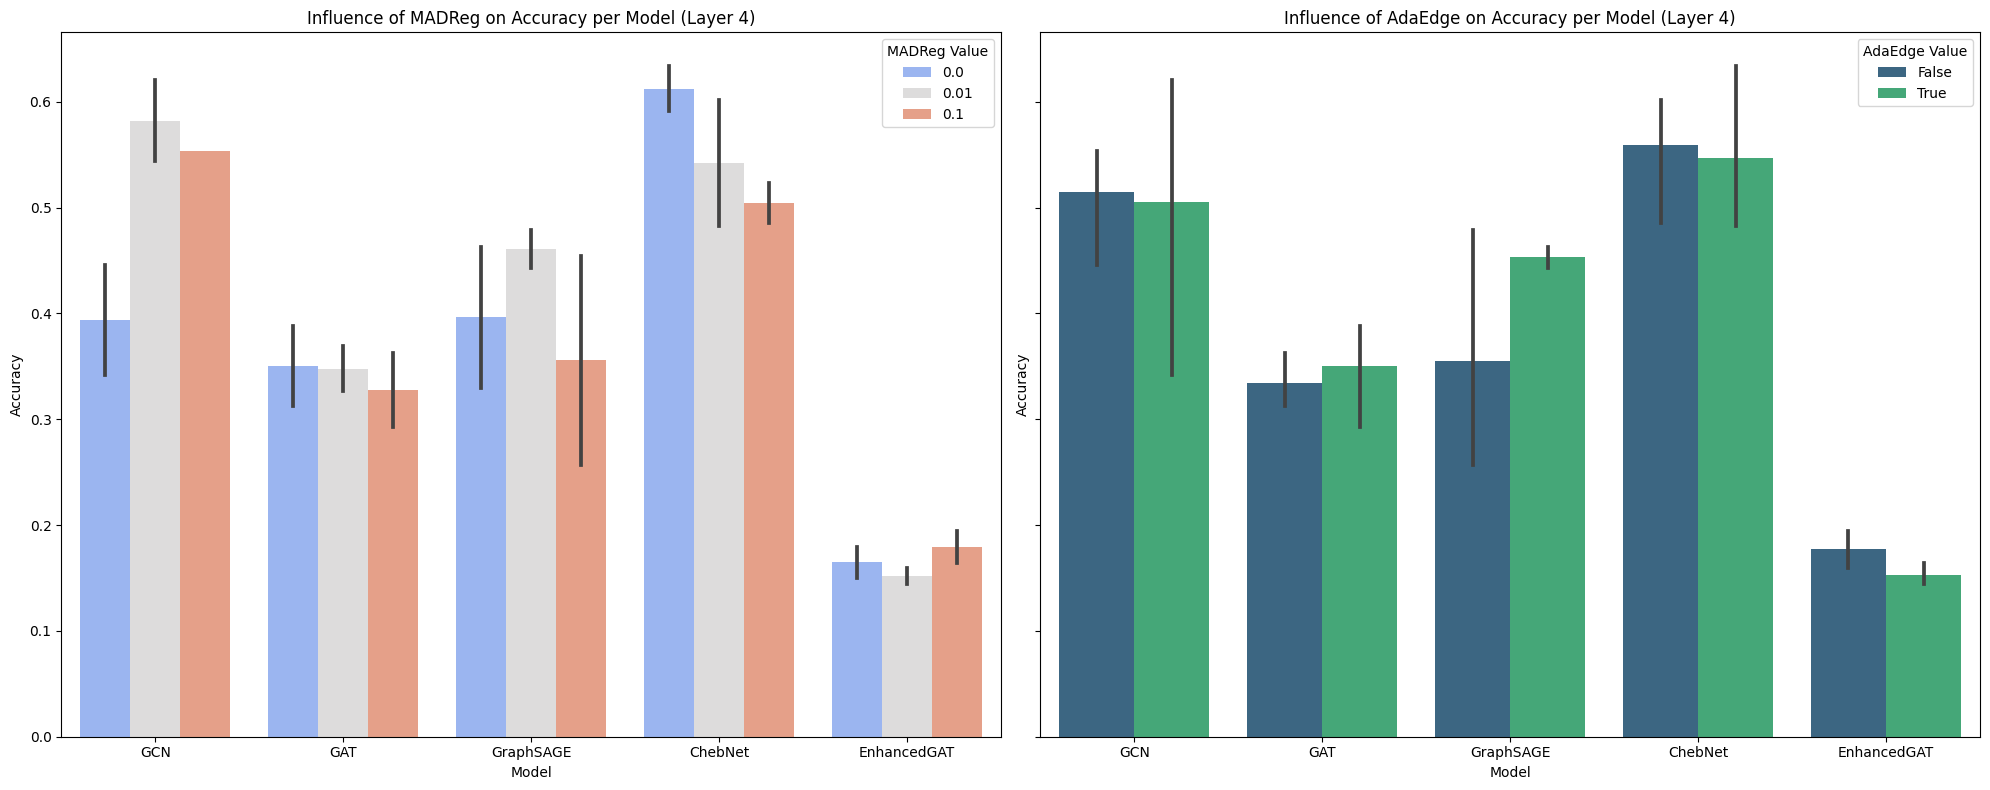

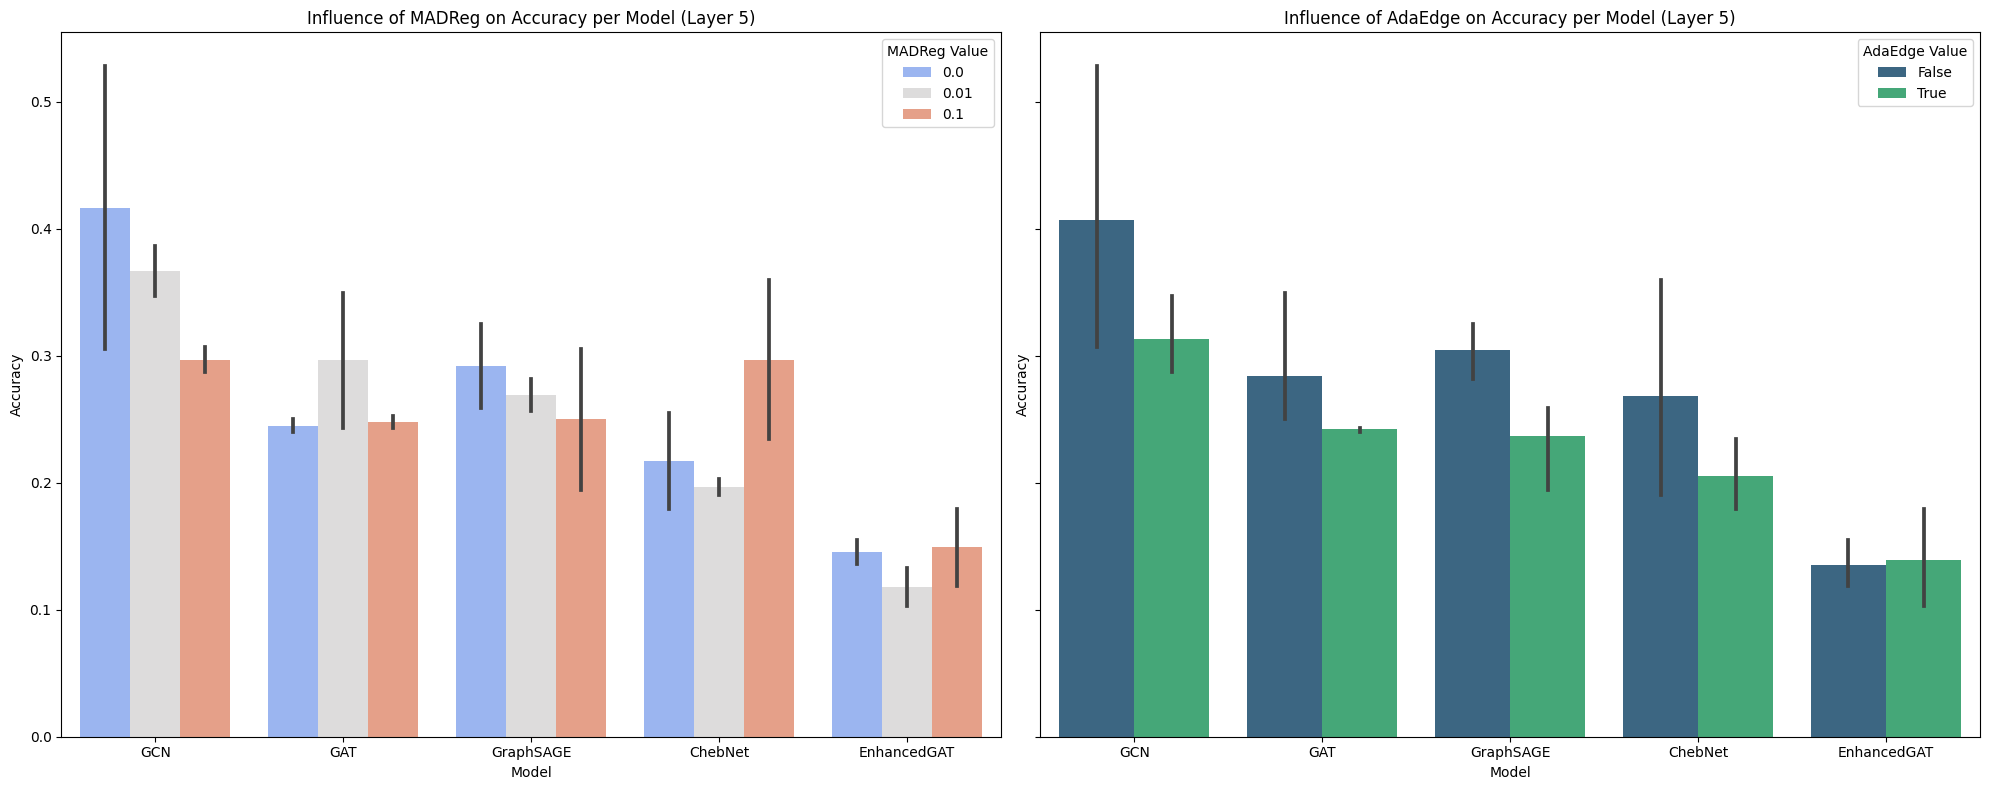

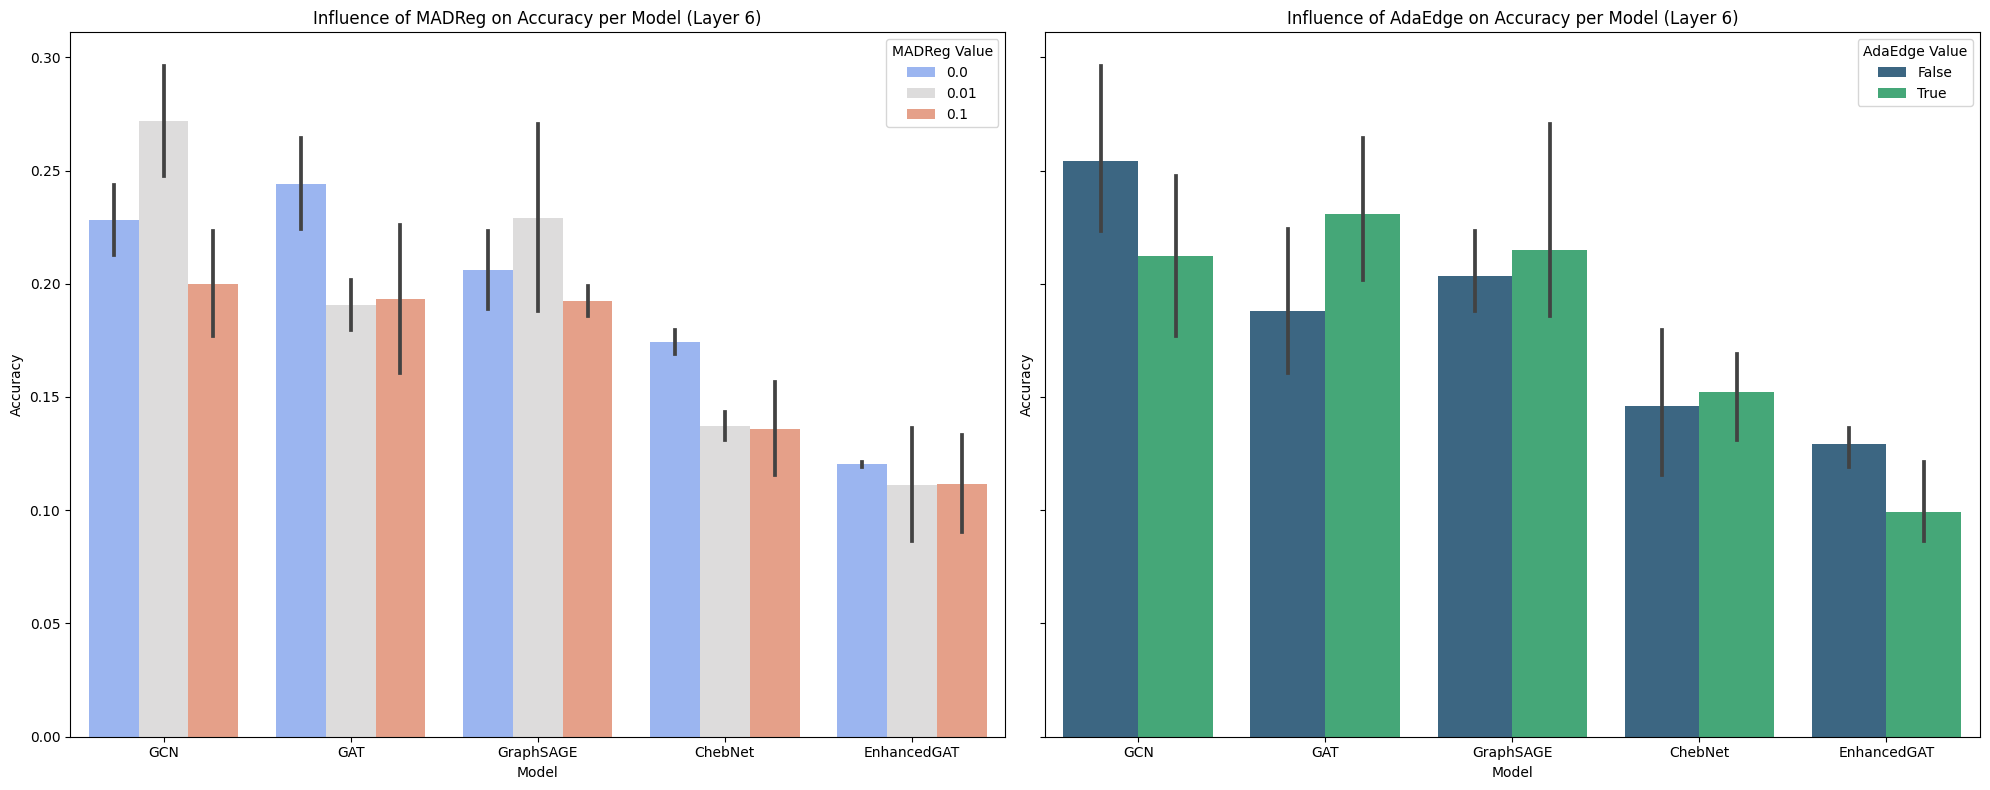

In [110]:
# Define your layer numbers
layers = [2, 3, 4, 5, 6]

madreg_palette = "coolwarm"
adaedge_palette = "viridis"

# Loop over each layer to create separate plots
for layer in layers:
    subset = results_df[results_df['Num_Layers'] == layer]

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    # First subplot for MADReg influence
    sns.barplot(ax=axes[0], data=subset, x='Model', y='Accuracy_mean', hue='MADReg', palette=madreg_palette)
    axes[0].set_title(f'Influence of MADReg on Accuracy per Model (Layer {layer})')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(title='MADReg Value')

    # Second subplot for AdaEdge influence
    sns.barplot(ax=axes[1], data=subset, x='Model', y='Accuracy_mean', hue='AdaEdge', palette=adaedge_palette)
    axes[1].set_title(f'Influence of AdaEdge on Accuracy per Model (Layer {layer})')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(title='AdaEdge Value')

    # Adjust the layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
